In [161]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

In [162]:
# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.384, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    alpha = 0.25,
    delta = 0.03,
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['alpha'] = alpha
    param['delta'] = delta

    return param

In [163]:
def solve_household(param, r, w):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

In [164]:
def get_distribution(param, decisions):

    NA = param['NA']
    NH = param['NH']
    iaplus = decisions[1]
    pi = param['pi']

    test = 10 # initialize a test value to be greater than 1e-8
    phi = np.ones((NA, NH))/NA/NH # initialize the distribution phi to be uniform

    # loop until the test value is less than 1e-8
    while test > 1e-8:
        phi_new = np.zeros((NA, NH)) # initialize a new distribution phi_new to be all zero values
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    phi_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * phi[ia, ih]

        test = np.max(np.abs(phi_new - phi)) # calculate the maximum difference
        phi = phi_new # update phi to be phi_new

    return phi

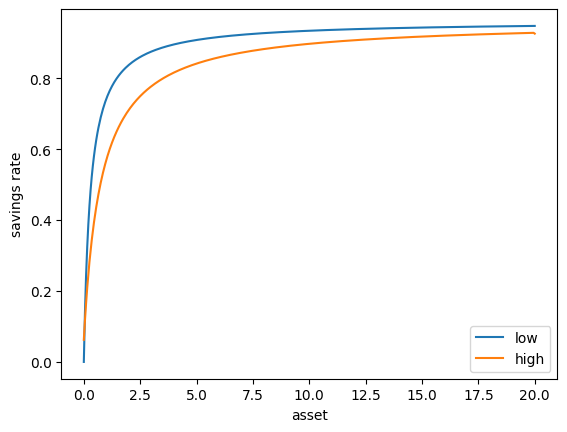

In [165]:
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar(beta = 0.98) # parameters
decisions = solve_household(param,r,w) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()

In [166]:
phi = get_distribution(param, decisions)

array([1.68244025e-158, 1.20662902e-156, 4.52086452e-155, 1.17638613e-153,
       2.38568448e-152, 4.01309520e-151, 5.82144232e-150, 7.47732914e-149,
       8.66773304e-148, 9.19891418e-147, 9.03816932e-146, 8.29461962e-145,
       7.16185230e-144, 5.85284752e-143, 4.54993951e-142, 3.37906902e-141,
       2.40622757e-140, 1.64819253e-139, 1.08898124e-138, 6.95727892e-138,
       4.30734236e-137, 2.58924076e-136, 1.51385199e-135, 8.62228308e-135,
       4.79075739e-134, 2.60008721e-133, 1.38001236e-132, 7.17060010e-132,
       3.65118068e-131, 1.82351897e-130, 8.94025572e-130, 4.30614605e-129,
       2.03910164e-128, 9.49927679e-128, 4.35626421e-127, 1.96771595e-126,
       8.75933920e-126, 3.84469955e-125, 1.66472847e-124, 7.11393250e-124,
       3.00154883e-123, 1.25090391e-122, 5.15120969e-122, 2.09679612e-121,
       8.43940051e-121, 3.35980820e-120, 1.32341746e-119, 5.15922093e-119,
       1.99111135e-118, 7.60929943e-118, 2.88031318e-117, 1.08014952e-116,
       4.01398463e-116, 1

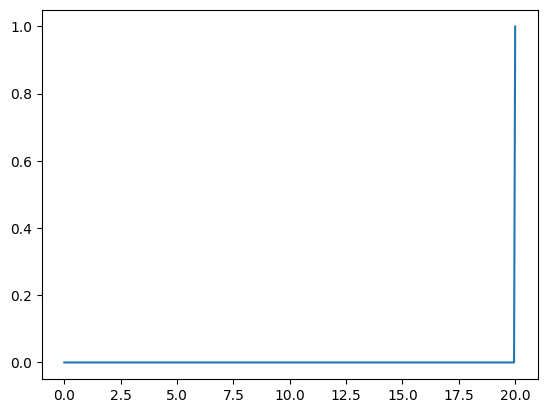

In [167]:
phi_asset = np.zeros(NA)

NH = param['NH']

for ia in range(NA):
    for ih in range(NH):
        phi_asset[ia] += phi[ia, ih]

display(phi_asset)

plt.plot(a, phi_asset)

19.999999994768597

0.7411492011232337

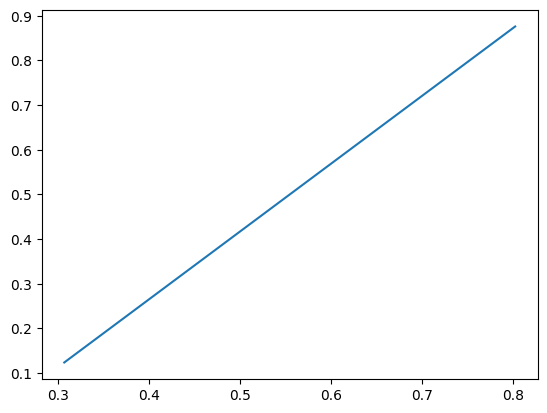

In [168]:
KK = np.sum(phi*aplus)
NH = param['NH']
h = param['h']
phi_h = np.zeros(NH)

for ia in range(NA):
    for ih in range(NH):
        phi_h[ih] += phi[ia, ih]

HH = np.sum(phi_h*h)

display(KK)
display(HH)

plt.plot(h, phi_h)

In [169]:

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar(beta = 0.98) # parameters

alpha = param['alpha']
delta = param['delta']
NH = param['NH']
h = param['h']

test = 10
while test > 1e-3:

    decisions = solve_household(param, r, w) # HH problem
    aplus = decisions[0]
    c = decisions[2]
    phi = get_distribution(param, decisions)

    # aggregation
    KK = np.sum(phi*aplus)
    phi_h = np.zeros(NH)

    for ia in range(NA):
        for ih in range(NH):
            phi_h[ih] += phi[ia, ih]

    HH = np.sum(phi_h*h)

    # update prices
    r_new = alpha * KK**(alpha-1) * HH**(1-alpha) - delta
    w_new = (1-alpha) * KK**alpha * HH**(-alpha)

    test = abs(w_new - w) + abs(r_new - r)

    r = 0.2*r_new + 0.8*r
    w = 0.2*w_new + 0.8*w

    display([test, r, w])

[0.7582794168842923, 0.030223055035862076, 1.1418789384127206]

[0.6066235335074338, 0.022401499064551737, 1.255382089142897]

[0.48529882680594705, 0.016144254287503466, 1.3461846097270382]

[0.38823906144475756, 0.011138458465864849, 1.4188266261943512]

[0.31059124915580605, 0.007133821808553955, 1.4769402393682016]

[0.24847299932464467, 0.00393011248270524, 1.5234311299072818]

[0.1987783994597158, 0.0013671450220262673, 1.5606238423385461]

[0.1590227195677725, -0.000683228946516911, 1.5903780122835576]

[0.12721817565421786, -0.0023235281213514537, 1.6141813482395666]

[0.1017745405233743, -0.003635767461219088, 1.633224017004374]

[0.08141963241869934, -0.0046855589331131955, 1.6484581520162198]

[0.0807003198965427, -0.004294714854111211, 1.6327089321159134]

[0.08127576991426774, -0.0052127168474268935, 1.6480460841054514]

[0.09912161536018976, -0.004531201631208685, 1.6289032762496318]

[0.06000869986897768, -0.004180950291681341, 1.6172517876153638]

[0.0968466789772472, -0.005121705197482998, 1.6356803685050116]

[0.08650310198356383, -0.00446006399642863, 1.6190413893093534]

[0.04961978169032123, -0.004128544050166456, 1.6094489529175515]

[0.10470191991657438, -0.0050797802042710895, 1.6294381007467618]

[0.08017377224364687, -0.004426990276365858, 1.6140561362259376]

[0.0445220574704368, -0.004102868974521832, 1.6054758460336942]

[0.10870070187607632, -0.005059240143755391, 1.626259615239676]

[0.07684012465860313, -0.004411948611884128, 1.6115388818398266]

[0.041989761419844125, -0.004090835642936448, 1.6034620425248056]

[0.11072653871655028, -0.005049613478487083, 1.6246485724325652]

[0.07521051605904128, -0.004404339588133969, 1.6102517431111103]

[0.040695013667377634, -0.004084748423936321, 1.6024323315418325]

[0.11176233691852352, -0.005044743703286982, 1.6238248036461866]

[0.0743409109521852, -0.004400866777981704, 1.609600498381055]

[0.04004029612717008, -0.004081970175814509, 1.6019113357577883]

[0.11228611095068952, -0.005042521104789532, 1.6234080070189514]

[0.0739218917264525, -0.004399088699183745, 1.609267061079267]

[0.03970508074658409, -0.004080547712776142, 1.6016445859163577]

[0.11255428325515848, -0.005041383134358838, 1.6231946071458068]

[0.07370735388287719, -0.004398178322839189, 1.6090963411807513]

KeyboardInterrupt: 